<a href="https://colab.research.google.com/github/harrymkwn/InfluenceAnalysis/blob/master/AllEmointnegpos4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split
from google.colab import  drive
drive.mount('/content/drive')
import nltk
from nltk.corpus import stopwords
nltk.download('all')
device_name = tf.test.gpu_device_name()
print(device_name)
df = pd.read_csv('/content/drive/MyDrive/InfluenceAnalysis/Data/Tweets_clean_data.csv')
df = df.sample(frac=1)

Mounted at /content/drive
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_esp.zip.
[nltk_data]    | Downloading package chat80 to /root/nltk_data...

In [ ]:
category_dict = {"anger":[1,0,0,0],"sadness":[0,1,0,0],"fear":[0,0,1,0],"joy":[0,0,0,1]}
data_tweet = [x.lower().split() for x in df['Tweet']]
data_cat = np.array([category_dict[x] for x in df['Emotion']])

In [ ]:
print(data_tweet[:5])
print(data_cat[:5])

[['oh', 'goodness', 'i', 'am', 'loving', 'this', 'rainy', 'day', 'it', 'is', 'a', 'head', 'down', 'creative', 'cap', 'on', 'and', 'get', 'lost', 'in', 'your', 'thoughts', 'kind', 'of', 'day', 'thought', 'balloon', 'smiling', 'face️', 'art', 'create', 'biz'], ['uplift', 'if', 'you', 'are', 'still', 'discouraged', 'it', 'means', 'ur', 'listening', 'to', 'the', 'wrong', 'voices', 'and', 'loking', 'to', 'the', 'wrong', 'source', 'lok', 'to', 'the', 'lord'], ['never', 'a', 'dull', 'moment', 'when', 'talking', 'to', 'nell', 'face', 'with', 'tears', 'of', 'joyface', 'with', 'tears', 'of', 'joyface', 'with', 'tears', 'of', 'joyface', 'with', 'tears', 'of', 'joyface', 'savouring', 'delicious', 'food'], ['i', 'added', 'paul', 'walker', 'on', 'xbox', 'but', 'he', 'just', 'spends', 'all', 'of', 'his', 'time', 'on', 'the', 'dashboard', 'humor', 'funny'], ['sorry', 'to', 'hear', 'about', 'your', 'experience', 'however', 'please', 'do', 'not', 'hesitate', 'to', 'contact', 'us', 'via', 'live', 'chat',

In [ ]:
# Parameters
Min_count = 0
Embedding_size = 100
Window_size = 5
Negative_sampling = 00

In [ ]:
w2v_sg = Word2Vec(min_count=Min_count,
                     window=Window_size,
                     size=Embedding_size,
                     negative=Negative_sampling,sg=1)
w2v_sg.build_vocab(data_tweet)
w2v_sg.train(data_tweet, total_examples=w2v_sg.corpus_count, epochs=5)
w2v_cbow = Word2Vec(min_count=Min_count,
                     window=Window_size,
                     size=Embedding_size,
                     negative=Negative_sampling,sg=0)
w2v_cbow.build_vocab(data_tweet)
w2v_cbow.train(data_tweet, total_examples=w2v_cbow.corpus_count, epochs=5)
w2v_sg.wv.init_sims(True)
w2v_cbow.wv.init_sims(True)

In [ ]:
vocab_sg = w2v_sg.wv.vocab
vocab_sg = [x for x in vocab_sg]
vocab_cbow = w2v_cbow.wv.vocab
vocab_cbow = [x for x in vocab_cbow] 
vocab_glove = {}
with open("/content/drive/My Drive/InfluenceAnalysis/glove/glove.twitter.27B.100d.txt", 'r', encoding="utf-8") as f:
  for line in f:
      values = line.split()
      word = values[0]
      vector = np.asarray(values[1:], "float32")
      vocab_glove[word] = vector

In [ ]:
batch_size = 100
Max_input_size = max([len(x) for x in data_tweet])
mul_factor=1.5

In [ ]:
positive = pd.read_csv('/content/drive/My Drive/InfluenceAnalysis/CodeMix/positive-words.csv')
positive = list(positive['0'][1:])
negative = pd.read_csv('/content/drive/My Drive/InfluenceAnalysis/CodeMix/negative-words.csv')
negative = list(negative['0'][2:])
pn_dict = {}
for i in range(len(positive)):
  pn_dict[positive[i]] = 1

for i in range(len(negative)):
  pn_dict[negative[i]] = -1

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_tweet, data_cat, test_size=0.30, random_state=42)
X_train = [nltk.pos_tag(x) for x in X_train]
X_test = [nltk.pos_tag(x) for x in X_test]
X_train = [[(i[0],i[1],pn_dict.get(i[0],1)) for i in x] for x in X_train]
X_test = [[(i[0],i[1],pn_dict.get(i[0],1)) for i in x] for x in X_test]
result_table = [0,0,0,0,0,0,0,0,0]

In [ ]:
def vec_gen(w2v,vocab,data_tweet,data_cat,batch_size,Max_input_size,Embedding_size,mul_factor):
  while True:
    for k in range(int(len(data_tweet)/batch_size)):
      res=[]
      for x in data_tweet[k*(batch_size):(k+1)*(batch_size)]:
        tweet = [(w2v.wv.word_vec(i[0]),i[1],i[2]) for i in x if i[0] in vocab]
        l=len(tweet)
        for i in range(l):
          tweet[i]=((tweet[i][0]*tweet[i][2]),tweet[i][1],tweet[i][2])
        for i in range(l):
          if tweet[i][1][:2]=='JJ' or tweet[i][1][:2]=='RB':
            tweet[i]=((tweet[i][0]*mul_factor),tweet[i][1],tweet[i][2])
        for i in range(l):
          if tweet[i][1][:2]=='JJ':
            for z in range(max(i-2,0),min(i+3,l)):
              if tweet[z][1][:2]=='NN':
                tweet[z]=((tweet[z][0]+tweet[i][0]),tweet[z][1])
          if tweet[i][1][:2]=='RB':
            for z in range(max(i-2,0),min(i+3,l)):
              if tweet[z][1][:2]=='VB':
                tweet[z]=((tweet[z][0]+tweet[i][0]),tweet[z][1])
        res+=[np.array([x[0] for x in tweet])]
      temp = np.array([np.pad(z.flatten(),(0,Max_input_size*Embedding_size-len(z.flatten()))).reshape(Max_input_size,Embedding_size) for z in res])
      tempres = data_cat[k*(batch_size):(k+1)*(batch_size)]
      yield (temp,tempres)          
      
def glove_gen(vocab,data_tweet,data_cat,batch_size,Max_input_size,Embedding_size,mul_factor):
  while True:
    for k in range(int(len(data_tweet)/batch_size)):
      res=[]
      for x in data_tweet[k*(batch_size):(k+1)*(batch_size)]:
        tweet = [(vocab[i[0]],i[1],i[2]) for i in x if i[0] in vocab.keys()]
        l=len(tweet)
        for i in range(l):
          tweet[i]=((tweet[i][0]*tweet[i][2]),tweet[i][1],tweet[i][2])
        for i in range(l):
          if tweet[i][1][:2]=='JJ' or tweet[i][1][:2]=='RB':
            tweet[i]=((tweet[i][0]*mul_factor),tweet[i][1],tweet[i][2])
        for i in range(l):
          if tweet[i][1][:2]=='JJ':
            for z in range(max(i-2,0),min(i+3,l)):
              if tweet[z][1][:2]=='NN':
                tweet[z]=((tweet[z][0]+tweet[i][0]),tweet[z][1])
          if tweet[i][1][:2]=='RB':
            for z in range(max(i-2,0),min(i+3,l)):
              if tweet[z][1][:2]=='VB':
                tweet[z]=((tweet[z][0]+tweet[i][0]),tweet[z][1])
        res+=[np.array([x[0] for x in tweet])]
      temp = np.array([np.pad(z.flatten(),(0,Max_input_size*Embedding_size-len(z.flatten()))).reshape(Max_input_size,Embedding_size) for z in res])
      tempres = data_cat[k*(batch_size):(k+1)*(batch_size)]
      yield (temp,tempres)

In [ ]:
epochs = 50

In [ ]:
model_sg = tf.keras.Sequential()
model_sg.add(tf.keras.Input(shape=(Max_input_size,Embedding_size)))
model_sg.add(tf.keras.layers.LSTM(50))
model_sg.add(tf.keras.layers.Dense(4, activation='softmax'))
model_sg.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy'])
history_sg_lstm = model_sg.fit_generator(generator = vec_gen(w2v_sg,vocab_sg,X_train,y_train,batch_size,Max_input_size,Embedding_size,mul_factor),steps_per_epoch=int(len(X_train)/batch_size),epochs=epochs)
history = model_sg.evaluate(x = vec_gen(w2v_sg,vocab_sg,X_test,y_test,batch_size,Max_input_size,Embedding_size,mul_factor),steps=int(len(y_test)/batch_size))
print(history)

result_table[0]=history[1]
print("SG_LSTM")


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
49/49 [==============================] - 4s 74ms/step - loss: 1.3786 - accuracy: 0.3149
Epoch 2/50
49/49 [==============================] - 4s 75ms/step - loss: 1.3758 - accuracy: 0.3171
Epoch 3/50
49/49 [==============================] - 4s 74ms/step - loss: 1.3757 - accuracy: 0.3173
Epoch 4/50
49/49 [==============================] - 4s 75ms/step - loss: 1.3754 - accuracy: 0.3173
Epoch 5/50
49/49 [==============================] - 4s 73ms/step - loss: 1.3752 - accuracy: 0.3173
Epoch 6/50
49/49 [==============================] - 4s 74ms/step - loss: 1.3751 - accuracy: 0.3173
Epoch 7/50
49/49 [==============================] - 4s 75ms/step - loss: 1.3750 - accuracy: 0.3173
Epoch 8/50
49/49 [==============================] - 4s 73ms/step - loss: 1.3749 - accuracy: 0.3173
Epoch 9/50
49/49 [==============================] - 4s 74ms/step - loss: 1.3748 - accuracy: 0.3173
Epoch 10/50
49/49 [==============

In [ ]:
model_sg_bi = tf.keras.Sequential()
model_sg_bi.add(tf.keras.Input(shape=(Max_input_size,Embedding_size)))
model_sg_bi.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50),merge_mode='concat'))
model_sg_bi.add(tf.keras.layers.Dense(4, activation='softmax'))
model_sg_bi.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy'])
history_sg_bi = model_sg_bi.fit_generator(generator = vec_gen(w2v_sg,vocab_sg,X_train,y_train,batch_size,Max_input_size,Embedding_size,mul_factor),steps_per_epoch=int(len(X_train)/batch_size),epochs=epochs)
history = model_sg_bi.evaluate(x = vec_gen(w2v_sg,vocab_sg,X_test,y_test,batch_size,Max_input_size,Embedding_size,mul_factor),steps=int(len(y_test)/batch_size))
print(history)

result_table[1]=history[1]
print("SG_BI")

Epoch 1/50
49/49 [==============================] - 4s 78ms/step - loss: 1.3750 - accuracy: 0.3127
Epoch 2/50
49/49 [==============================] - 4s 79ms/step - loss: 1.3509 - accuracy: 0.3359
Epoch 3/50
49/49 [==============================] - 4s 79ms/step - loss: 1.3158 - accuracy: 0.3669
Epoch 4/50
49/49 [==============================] - 4s 80ms/step - loss: 1.2850 - accuracy: 0.3955
Epoch 5/50
49/49 [==============================] - 4s 79ms/step - loss: 1.2574 - accuracy: 0.4233
Epoch 6/50
49/49 [==============================] - 4s 78ms/step - loss: 1.2279 - accuracy: 0.4406
Epoch 7/50
49/49 [==============================] - 4s 78ms/step - loss: 1.2031 - accuracy: 0.4637
Epoch 8/50
49/49 [==============================] - 4s 79ms/step - loss: 1.1782 - accuracy: 0.4816
Epoch 9/50
49/49 [==============================] - 4s 78ms/step - loss: 1.1542 - accuracy: 0.4955
Epoch 10/50
49/49 [==============================] - 4s 82ms/step - loss: 1.1306 - accuracy: 0.5129
Epoch 11/

In [ ]:
model_sg_rnn = tf.keras.Sequential()
model_sg_rnn.add(tf.keras.Input(shape=(Max_input_size,Embedding_size)))
model_sg_rnn.add(tf.keras.layers.SimpleRNN(50))
model_sg_rnn.add(tf.keras.layers.Dense(4, activation='softmax'))
model_sg_rnn.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy'])
history_sg_rnn = model_sg_rnn.fit_generator(generator = vec_gen(w2v_sg,vocab_sg,X_train,y_train,batch_size,Max_input_size,Embedding_size,mul_factor),steps_per_epoch=int(len(X_train)/batch_size),epochs=epochs)
history = model_sg_rnn.evaluate(x = vec_gen(w2v_sg,vocab_sg,X_test,y_test,batch_size,Max_input_size,Embedding_size,mul_factor),steps=int(len(y_test)/batch_size))
print(history)


result_table[2]=history[1]
print("SG_RNN")

Epoch 1/50
49/49 [==============================] - 5s 107ms/step - loss: 1.3801 - accuracy: 0.3086
Epoch 2/50
49/49 [==============================] - 5s 107ms/step - loss: 1.3750 - accuracy: 0.3124
Epoch 3/50
49/49 [==============================] - 5s 107ms/step - loss: 1.3679 - accuracy: 0.3190
Epoch 4/50
49/49 [==============================] - 5s 104ms/step - loss: 1.3604 - accuracy: 0.3224
Epoch 5/50
49/49 [==============================] - 5s 105ms/step - loss: 1.3516 - accuracy: 0.3404
Epoch 6/50
49/49 [==============================] - 5s 107ms/step - loss: 1.3284 - accuracy: 0.3639
Epoch 7/50
49/49 [==============================] - 5s 107ms/step - loss: 1.2996 - accuracy: 0.3867
Epoch 8/50
49/49 [==============================] - 5s 108ms/step - loss: 1.2798 - accuracy: 0.4106
Epoch 9/50
49/49 [==============================] - 5s 106ms/step - loss: 1.2490 - accuracy: 0.4302
Epoch 10/50
49/49 [==============================] - 5s 106ms/step - loss: 1.2263 - accuracy: 0.4455

In [ ]:
model_cbow = tf.keras.Sequential()
model_cbow.add(tf.keras.Input(shape=(Max_input_size,Embedding_size)))
model_cbow.add(tf.keras.layers.LSTM(50))
model_cbow.add(tf.keras.layers.Dense(4, activation='softmax'))
model_cbow.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy'])
history_cbow_lstm = model_cbow.fit_generator(generator = vec_gen(w2v_cbow,vocab_cbow,X_train,y_train,batch_size,Max_input_size,Embedding_size,mul_factor),steps_per_epoch=int(len(X_train)/batch_size),epochs=epochs)
history = model_cbow.evaluate(x = vec_gen(w2v_cbow,vocab_cbow,X_test,y_test,batch_size,Max_input_size,Embedding_size,mul_factor),steps=int(len(y_test)/batch_size))
print(history)

result_table[3]=history[1]
print("CBOW_LSTM")

Epoch 1/50
49/49 [==============================] - 4s 73ms/step - loss: 1.3787 - accuracy: 0.3153
Epoch 2/50
49/49 [==============================] - 4s 78ms/step - loss: 1.3760 - accuracy: 0.3171
Epoch 3/50
49/49 [==============================] - 4s 80ms/step - loss: 1.3756 - accuracy: 0.3173
Epoch 4/50
49/49 [==============================] - 4s 80ms/step - loss: 1.3754 - accuracy: 0.3173
Epoch 5/50
49/49 [==============================] - 4s 73ms/step - loss: 1.3752 - accuracy: 0.3173
Epoch 6/50
49/49 [==============================] - 4s 74ms/step - loss: 1.3750 - accuracy: 0.3173
Epoch 7/50
49/49 [==============================] - 4s 73ms/step - loss: 1.3749 - accuracy: 0.3173
Epoch 8/50
49/49 [==============================] - 4s 73ms/step - loss: 1.3749 - accuracy: 0.3173
Epoch 9/50
49/49 [==============================] - 4s 73ms/step - loss: 1.3748 - accuracy: 0.3173
Epoch 10/50
49/49 [==============================] - 4s 74ms/step - loss: 1.3747 - accuracy: 0.3173
Epoch 11/

In [ ]:
model_cbow_bi = tf.keras.Sequential()
model_cbow_bi.add(tf.keras.Input(shape=(Max_input_size,Embedding_size)))
model_cbow_bi.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50),merge_mode='concat'))
model_cbow_bi.add(tf.keras.layers.Dense(4, activation='softmax'))
model_cbow_bi.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy'])
history_cbow_bi = model_cbow_bi.fit_generator(generator = vec_gen(w2v_cbow,vocab_cbow,X_train,y_train,batch_size,Max_input_size,Embedding_size,mul_factor),steps_per_epoch=int(len(X_train)/batch_size),epochs=epochs)
history = model_cbow_bi.evaluate(x = vec_gen(w2v_cbow,vocab_cbow,X_test,y_test,batch_size,Max_input_size,Embedding_size,mul_factor),steps=int(len(y_test)/batch_size))
print(history)

result_table[4]=history[1]
print("CBOW_BI")

Epoch 1/50
49/49 [==============================] - 4s 77ms/step - loss: 1.3725 - accuracy: 0.3167
Epoch 2/50
49/49 [==============================] - 4s 77ms/step - loss: 1.3471 - accuracy: 0.3414
Epoch 3/50
49/49 [==============================] - 4s 76ms/step - loss: 1.3166 - accuracy: 0.3692
Epoch 4/50
49/49 [==============================] - 4s 78ms/step - loss: 1.2885 - accuracy: 0.3971
Epoch 5/50
49/49 [==============================] - 4s 78ms/step - loss: 1.2638 - accuracy: 0.4100
Epoch 6/50
49/49 [==============================] - 4s 78ms/step - loss: 1.2335 - accuracy: 0.4369
Epoch 7/50
49/49 [==============================] - 4s 76ms/step - loss: 1.2103 - accuracy: 0.4541
Epoch 8/50
49/49 [==============================] - 4s 77ms/step - loss: 1.1859 - accuracy: 0.4686
Epoch 9/50
49/49 [==============================] - 4s 76ms/step - loss: 1.1612 - accuracy: 0.4896
Epoch 10/50
49/49 [==============================] - 4s 77ms/step - loss: 1.1365 - accuracy: 0.5069
Epoch 11/

In [ ]:
model_cbow_rnn = tf.keras.Sequential()
model_cbow_rnn.add(tf.keras.Input(shape=(Max_input_size,Embedding_size)))
model_cbow_rnn.add(tf.keras.layers.SimpleRNN(50))
model_cbow_rnn.add(tf.keras.layers.Dense(4, activation='softmax'))
model_cbow_rnn.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy'])
history_cbow_rnn = model_cbow_rnn.fit_generator(generator = vec_gen(w2v_cbow,vocab_cbow,X_train,y_train,batch_size,Max_input_size,Embedding_size,mul_factor),steps_per_epoch=int(len(X_train)/batch_size),epochs=epochs)
history = model_cbow_rnn.evaluate(x = vec_gen(w2v_cbow,vocab_cbow,X_test,y_test,batch_size,Max_input_size,Embedding_size,mul_factor),steps=int(len(y_test)/batch_size))
print(history)

result_table[5]=history[1]
print("CBOW_RNN")

Epoch 1/50
49/49 [==============================] - 5s 104ms/step - loss: 1.3800 - accuracy: 0.3096
Epoch 2/50
49/49 [==============================] - 5s 103ms/step - loss: 1.3749 - accuracy: 0.3104
Epoch 3/50
49/49 [==============================] - 5s 103ms/step - loss: 1.3689 - accuracy: 0.3122
Epoch 4/50
49/49 [==============================] - 5s 105ms/step - loss: 1.3618 - accuracy: 0.3108
Epoch 5/50
49/49 [==============================] - 5s 104ms/step - loss: 1.3639 - accuracy: 0.3337
Epoch 6/50
49/49 [==============================] - 5s 104ms/step - loss: 1.3544 - accuracy: 0.3365
Epoch 7/50
49/49 [==============================] - 5s 103ms/step - loss: 1.3436 - accuracy: 0.3467
Epoch 8/50
49/49 [==============================] - 5s 101ms/step - loss: 1.3298 - accuracy: 0.3651
Epoch 9/50
49/49 [==============================] - 5s 103ms/step - loss: 1.3281 - accuracy: 0.3645
Epoch 10/50
49/49 [==============================] - 5s 102ms/step - loss: 1.3186 - accuracy: 0.3653

In [ ]:
model_glove = tf.keras.Sequential()
model_glove.add(tf.keras.Input(shape=(Max_input_size,100)))
model_glove.add(tf.keras.layers.LSTM(50))
model_glove.add(tf.keras.layers.Dense(4, activation='softmax'))
model_glove.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy'])
history_glove_lstm = model_glove.fit_generator(generator = glove_gen(vocab_glove,X_train,y_train,batch_size,Max_input_size,Embedding_size,mul_factor),steps_per_epoch=int(len(X_train)/batch_size),epochs=epochs)
history = model_glove.evaluate(x = glove_gen(vocab_glove,X_test,y_test,batch_size,Max_input_size,Embedding_size,mul_factor),steps=int(len(y_test)/batch_size))
print(history)

result_table[6]=history[1]
print("GLOVE_LSTM")


Epoch 1/50
49/49 [==============================] - 1s 23ms/step - loss: 1.3788 - accuracy: 0.3133
Epoch 2/50
49/49 [==============================] - 1s 24ms/step - loss: 1.3439 - accuracy: 0.3339
Epoch 3/50
49/49 [==============================] - 1s 23ms/step - loss: 1.2244 - accuracy: 0.4263
Epoch 4/50
49/49 [==============================] - 1s 23ms/step - loss: 1.1176 - accuracy: 0.4847
Epoch 5/50
49/49 [==============================] - 1s 24ms/step - loss: 1.0319 - accuracy: 0.5410
Epoch 6/50
49/49 [==============================] - 1s 24ms/step - loss: 0.9798 - accuracy: 0.5627
Epoch 7/50
49/49 [==============================] - 1s 23ms/step - loss: 0.9357 - accuracy: 0.5782
Epoch 8/50
49/49 [==============================] - 1s 23ms/step - loss: 0.8732 - accuracy: 0.6147
Epoch 9/50
49/49 [==============================] - 1s 23ms/step - loss: 0.8782 - accuracy: 0.6018
Epoch 10/50
49/49 [==============================] - 1s 24ms/step - loss: 0.8289 - accuracy: 0.6288
Epoch 11/

In [ ]:
model_glove_bi = tf.keras.Sequential()
model_glove_bi.add(tf.keras.Input(shape=(Max_input_size,100)))
model_glove_bi.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50),merge_mode='concat'))
model_glove_bi.add(tf.keras.layers.Dense(4, activation='softmax'))
model_glove_bi.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy'])
history_glove_bi = model_glove_bi.fit_generator(generator = glove_gen(vocab_glove,X_train,y_train,batch_size,Max_input_size,Embedding_size,mul_factor),steps_per_epoch=int(len(X_train)/batch_size),epochs=epochs)
history = model_glove_bi.evaluate(x = glove_gen(vocab_glove,X_test,y_test,batch_size,Max_input_size,Embedding_size,mul_factor),steps=int(len(y_test)/batch_size))
print(history)

result_table[7]=history[1]
print("GLOVE_BI")

Epoch 1/50
49/49 [==============================] - 2s 32ms/step - loss: 1.3490 - accuracy: 0.3441
Epoch 2/50
49/49 [==============================] - 2s 32ms/step - loss: 1.2153 - accuracy: 0.4394
Epoch 3/50
49/49 [==============================] - 2s 32ms/step - loss: 1.1289 - accuracy: 0.4949
Epoch 4/50
49/49 [==============================] - 2s 32ms/step - loss: 1.0409 - accuracy: 0.5618
Epoch 5/50
49/49 [==============================] - 2s 32ms/step - loss: 0.9486 - accuracy: 0.6112
Epoch 6/50
49/49 [==============================] - 2s 32ms/step - loss: 0.8333 - accuracy: 0.6776
Epoch 7/50
49/49 [==============================] - 2s 32ms/step - loss: 0.7272 - accuracy: 0.7229
Epoch 8/50
49/49 [==============================] - 2s 32ms/step - loss: 0.6389 - accuracy: 0.7590
Epoch 9/50
49/49 [==============================] - 2s 32ms/step - loss: 0.5574 - accuracy: 0.7976
Epoch 10/50
49/49 [==============================] - 2s 32ms/step - loss: 0.4871 - accuracy: 0.8282
Epoch 11/

In [ ]:
model_glove_rnn = tf.keras.Sequential()
model_glove_rnn.add(tf.keras.Input(shape=(Max_input_size,100)))
model_glove_rnn.add(tf.keras.layers.SimpleRNN(50))
model_glove_rnn.add(tf.keras.layers.Dense(4, activation='softmax'))
model_glove_rnn.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy'])
history_glove_rnn = model_glove_rnn.fit_generator(generator = glove_gen(vocab_glove,X_train,y_train,batch_size,Max_input_size,Embedding_size,mul_factor),steps_per_epoch=int(len(X_train)/batch_size),epochs=epochs)
history = model_glove_rnn.evaluate(x = glove_gen(vocab_glove,X_test,y_test,batch_size,Max_input_size,Embedding_size,mul_factor),steps=int(len(y_test)/batch_size))
print(history)

result_table[8]=history[1]
print("GLOVE_RNN")

Epoch 1/50
49/49 [==============================] - 3s 68ms/step - loss: 1.3692 - accuracy: 0.3171
Epoch 2/50
49/49 [==============================] - 3s 67ms/step - loss: 1.3184 - accuracy: 0.3865
Epoch 3/50
49/49 [==============================] - 3s 66ms/step - loss: 1.2916 - accuracy: 0.4047
Epoch 4/50
49/49 [==============================] - 3s 68ms/step - loss: 1.2911 - accuracy: 0.4086
Epoch 5/50
49/49 [==============================] - 3s 67ms/step - loss: 1.3772 - accuracy: 0.2949
Epoch 6/50
49/49 [==============================] - 3s 66ms/step - loss: 1.3772 - accuracy: 0.3102
Epoch 7/50
49/49 [==============================] - 3s 69ms/step - loss: 1.3759 - accuracy: 0.3129
Epoch 8/50
49/49 [==============================] - 3s 68ms/step - loss: 1.3748 - accuracy: 0.3129
Epoch 9/50
49/49 [==============================] - 3s 69ms/step - loss: 1.3737 - accuracy: 0.3131
Epoch 10/50
49/49 [==============================] - 3s 68ms/step - loss: 1.3748 - accuracy: 0.3141
Epoch 11/

	Lstm			BiLstm			Rnn
sg [0.4338095188140869, 0.5019047856330872, 0.28952381014823914]
cbow [0.4695238173007965, 0.49095237255096436, 0.284761905670166]
glove [0.677142858505249, 0.6995238065719604, 0.3709523677825928]
{'loss': [1.3749839067459106, 1.3508803844451904, 1.3157767057418823, 1.2849596738815308, 1.2573941946029663, 1.2278952598571777, 1.2031220197677612, 1.1781833171844482, 1.1541719436645508, 1.1306248903274536, 1.1044827699661255, 1.0764265060424805, 1.046570062637329, 1.0231599807739258, 1.1099931001663208, 1.03123939037323, 0.9778082966804504, 0.9436726570129395, 0.9107797741889954, 0.8777619004249573, 0.8700494170188904, 0.8369972705841064, 0.8043699860572815, 0.7844513058662415, 0.7778325080871582, 0.7237404584884644, 0.7029338479042053, 0.7187485694885254, 0.6683573126792908, 0.6539459824562073, 0.6393826007843018, 0.6118651032447815, 0.5946564078330994, 0.5819164514541626, 0.5340105295181274, 0.586824893951416, 0.5254393219947815, 0.5512738227844238, 0.55849266052246

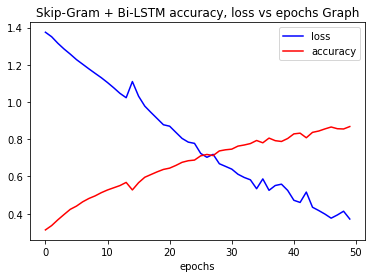

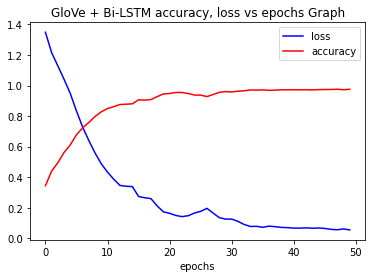

In [ ]:
print("\tLstm\t\t\tBiLstm\t\t\tRnn")
print("sg",result_table[:3])
print("cbow",result_table[3:6])
print("glove",result_table[6:9])
print(history_sg_bi.history)
plt.title("Skip-Gram + Bi-LSTM accuracy, loss vs epochs Graph")
plt.plot(history_sg_bi.history['loss'],c='b',label='loss')
plt.plot(history_sg_bi.history['accuracy'],c='r',label='accuracy')
plt.xlabel('epochs')
plt.legend()
# plt.yticks()
plt.show()
plt.title("GloVe + Bi-LSTM accuracy, loss vs epochs Graph")
plt.plot(history_glove_bi.history['loss'],c='b',label='loss')
plt.plot(history_glove_bi.history['accuracy'],c='r',label='accuracy')
plt.xlabel('epochs')
plt.legend()
# plt.yticks()
plt.show()